In [1]:
import titanlib
import geopandas
import pandas as pd
import netCDF4
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import titanlibcustom

## Import Boundaries Data and WOW Data

In [3]:
base_path = r"/home/matt/Documents/Met_Eireann/Data/"

# Import and define the boundaries for the counties of the island of Ireland
path_to_ROI_boundaries_data = base_path + r"Boundaries/Republic of Ireland Counties - shp/7829fd91-e0c3-4246-8fb5-100f3b62f8272020329-1-8mtzfa.iikfy.shp"
path_to_NI_boundaries_data = base_path + r"Boundaries/Northern Ireland Counties - shp/OSNI_Open_Data_-_50K_Boundaries_-_NI_Counties.shp"

ROI_counties = geopandas.read_file(path_to_ROI_boundaries_data)
NI_counties = geopandas.read_file(path_to_NI_boundaries_data)

# Note that we will use the Irish Grid projection so that we can get accurate distances
ROI_counties = ROI_counties.to_crs({'init': 'epsg:29902'}) # Convert maps to the same coordinate reference system
NI_counties = NI_counties.to_crs({'init': 'epsg:29902'})  # Convert maps to the same coordinate reference system

# Plot counties
# ax = ROI_counties["geometry"].plot()
# NI_counties["geometry"].plot(ax=ax)

## Import WOW Data

In [4]:
# Import Raw Wow data for the month of May
path_to_raw_wow_data = base_path + r"WOW_May_2021.csv"

raw_wow = pd.read_csv(path_to_raw_wow_data, dtype = {"Ground State":"string"})

# Create Day, Month, Year and Time columns
tmp = raw_wow["Report Date / Time"].str.split("-", expand=True)
tmp2 = tmp.iloc[:,2].str.split(" ", expand=True)

raw_wow["Day"] = tmp2.iloc[:,0]
raw_wow["Month"] = tmp.iloc[:,1]
raw_wow["Year"] = tmp.iloc[:,0]
raw_wow["Time"] = tmp2.iloc[:,1]

raw_wow.loc[raw_wow["Time"].isna(), "Time"] = "00:00:00" # Replace "missing" values with midnight



# Define a dataframe for the Rain Accumulation data
rain_wow = raw_wow[['Id', 'Site Id', 'Longitude', 'Latitude', 'Report Date / Time',
                    'Day', 'Month', 'Year', 'Time', 'Rainfall Accumulation']].copy()

# Remove any missing values
rain_wow_comp = rain_wow.copy().dropna()



# Define a dataframe for the Air Temperature data
temp_wow = raw_wow[['Id', 'Site Id', 'Longitude', 'Latitude', 'Report Date / Time',
                    'Day', 'Month', 'Year', 'Time', 'Air Temperature']].copy()

# Remove any missing values
temp_wow_comp = temp_wow.copy().dropna()

## Import Official Data

In [5]:
##### Temperature Data #####


# Import Raw Official data for the month of May
path_to_raw_official_data = base_path + r"All stations May 2021 Full (updated lat long).csv"
raw_official = pd.read_csv(path_to_raw_official_data)


# Create Day, Month, Year and Time columns
tmp = raw_official["datein"].str.split("-", expand=True)
tmp2 = tmp.iloc[:,2].str.split("\xa0", expand=True)

raw_official["Day"] = tmp.iloc[:,0]
raw_official["Month"] = tmp.iloc[:,1]
raw_official["Year"] = tmp2.iloc[:,0]
raw_official["Time"] = tmp2.iloc[:,1]


# Define a dataframe for the Temperature data
temp_official = raw_official[['filetag', 'stationid', 'long', 'lat', 'datein','t1dry', 't2dry',
                              'Day', 'Month', 'Year', 'Time']].copy()
# Replace values of -99.0 with missing values to be removed
temp_official.loc[temp_official["t1dry"] == -99.0, "t1dry"] = np.nan


# Remove any missing values
temp_official_comp = temp_official.copy().dropna()
temp_official_comp.replace("May", "05", inplace=True, regex=True) # Replace month with number
temp_official_comp.rename(columns={"t1dry":"Air Temperature", # Select t1dry as our temp obs
                                   "long":"Longitude", 
                                   "lat":"Latitude"}, inplace=True) 




##### Rainfall Data #####

# Import Raw Official rainfall data for the month of May
path_to_raw_official_rain_data = base_path + r"Rainfall stations May 2021.csv"
raw_official_rain = pd.read_csv(path_to_raw_official_rain_data)

# Create Day, Month, Year and Time columns
tmp = raw_official_rain["datein"].str.split("-", expand=True)
tmp2 = tmp.iloc[:,2].str.split("\xa0", expand=True)

raw_official_rain["Day"] = tmp.iloc[:,0]
raw_official_rain["Month"] = tmp.iloc[:,1]
raw_official_rain["Year"] = tmp2.iloc[:,0]
raw_official_rain["Time"] = tmp2.iloc[:,1]

# Define a dataframe for the Rain Accumulation data
rain_official = raw_official_rain[['filetag', 'stationid', 'long', 'lat', 'datein', 
                                   'totalpluvioaccrt_nrt','totalpluvioaccnrt', 'pluviohourrain',
                                   'Day', 'Month', 'Year', 'Time']]

# Remove any missing values
rain_official_comp = rain_official.copy().dropna()
rain_official_comp.replace("May", "05", inplace=True, regex=True) # Replace month with number
rain_official_comp.rename(columns={"totalpluvioaccrt_nrt":"Rainfall Accumulation", # Select real time rainfall as our value
                                   "long":"Longitude", 
                                   "lat":"Latitude"}, inplace=True)

## Define a function to isolate the data from the date, time and data of interest

In [6]:
def isolate_data_of_interest(day_of_interest, month_of_interest, year_of_interest, time_of_interest,
                             type_of_plot = "Air Temperature"):
    """
    This function isolates the data of interest.
    
    Inputs: 
    1. day_of_interest must be "DD"
    2. month_of_interest must be "MM"
    3. year_of_interest must be "YYYY"
    4. time_of_interest must be of the 24 hour format "HH" and will isolate data from the times between HH and HH+1
    5. type_of_plot must be either "Rainfall Accumulation" or "Air Temperature"
    
    Outputs:
    1. geodataframe of wow data of interest
    2. geodataframe of official data of interest
    3. geodataframe of combined data of interest
    """  

    if type_of_plot == "Rainfall Accumulation":
        
        ##### WOW Data #####
        
        # Isolate the data at that date and time
        rain_wow_comp_time_of_int = rain_wow_comp.loc[(rain_wow_comp["Day"] == day_of_interest) & 
                                                      (rain_wow_comp["Month"] == month_of_interest) &
                                                      (rain_wow_comp["Year"] == year_of_interest) & 
                                                      (rain_wow_comp["Time"].str[:2] == time_of_interest),].copy()

        
        # In the rainfall accumulation case we want to keep only the last observation 
        # before the hour of interest is finished
        rain_wow_comp_time_of_int_last_obs = rain_wow_comp_time_of_int.drop_duplicates(subset="Site Id", 
                                                                                       keep="last")

        # Convert data of interest into a GeoDataFrame for plotting
        gdf_wow = geopandas.GeoDataFrame(rain_wow_comp_time_of_int_last_obs, 
                                         geometry=geopandas.points_from_xy(
                                             rain_wow_comp_time_of_int_last_obs.Longitude, 
                                             rain_wow_comp_time_of_int_last_obs.Latitude))
        
        gdf_wow.crs = {"init":"epsg:4326"} # initialise the dataframe to have a crs
        gdf_wow = gdf_wow.to_crs({'init': 'epsg:29902'}) # convert crs to Irish Grid Projection
        
        
        ##### Official Data #####
        
        # Isolate the data at that date and time
        rain_official_comp_time_of_int = rain_official_comp.loc[(rain_official_comp["Day"] == day_of_interest) & 
                                                                (rain_official_comp["Month"] == month_of_interest) &
                                                                (rain_official_comp["Year"] == year_of_interest) & 
                                                                (rain_official_comp["Time"].str[:2] == time_of_interest),].copy()
        
        # In the rainfall accumulation case we want to keep only the last observation 
        # before the hour of interest is finished
        rain_official_comp_time_of_int_last_obs = rain_official_comp_time_of_int.drop_duplicates(subset="stationid",
                                                                                                 keep="last")

        # Convert data of interest into a GeoDataFrame for plotting
        gdf_official = geopandas.GeoDataFrame(rain_official_comp_time_of_int_last_obs, 
                                              geometry=geopandas.points_from_xy(
                                                  rain_official_comp_time_of_int_last_obs.Longitude, 
                                                  rain_official_comp_time_of_int_last_obs.Latitude))
        
        gdf_official.crs = {"init":"epsg:4326"} # initialise the dataframe to have a crs
        gdf_official = gdf_official.to_crs({'init': 'epsg:29902'}) # convert crs to Irish Grid Projection
        
        
        ##### Combined Data #####
        
        # Combine data frames
        gdf_combined = gdf_wow.append(gdf_official)
        
        
    elif type_of_plot == "Air Temperature":
        
        ##### WOW Data #####
        
        # Isolate the data at that date and time
        temp_wow_comp_time_of_int = temp_wow_comp.loc[(temp_wow_comp["Day"] == day_of_interest) & 
                                                      (temp_wow_comp["Month"] == month_of_interest) &
                                                      (temp_wow_comp["Year"] == year_of_interest) & 
                                                      (temp_wow_comp["Time"].str[:2] == time_of_interest),].copy()
        
        # In the temperature case we want to keep only the last observation 
        # before the hour of interest is finished
        temp_wow_comp_time_of_int_last_obs = temp_wow_comp_time_of_int.drop_duplicates(subset="Site Id", 
                                                                                       keep="last")

        # Convert data of interest into a GeoDataFrame for plotting
        gdf_wow = geopandas.GeoDataFrame(temp_wow_comp_time_of_int_last_obs,
                                         geometry=geopandas.points_from_xy(
                                             temp_wow_comp_time_of_int_last_obs.Longitude, 
                                             temp_wow_comp_time_of_int_last_obs.Latitude))
        
        gdf_wow.crs = {"init":"epsg:4326"} # initialise the dataframe to have a crs
        gdf_wow = gdf_wow.to_crs({'init': 'epsg:29902'}) # convert crs to Irish Grid Projection
        
        
        ##### Official Data #####
        
        # Isolate the data at that date and time
        temp_official_comp_time_of_int = temp_official_comp.loc[(temp_official_comp["Day"] == day_of_interest) & 
                                                                (temp_official_comp["Month"] == month_of_interest) &
                                                                (temp_official_comp["Year"] == year_of_interest) & 
                                                                (temp_official_comp["Time"].str[:2] == time_of_interest),].copy()
        
        # In the temperature case we want to keep only the last observation 
        # before the hour of interest is finished
        temp_offical_comp_time_of_int_last_obs = temp_official_comp_time_of_int.drop_duplicates(subset="stationid",
                                                                                                keep="last")

        # Convert data of interest into a GeoDataFrame for plotting
        gdf_official = geopandas.GeoDataFrame(temp_offical_comp_time_of_int_last_obs,
                                              geometry=geopandas.points_from_xy(
                                                  temp_offical_comp_time_of_int_last_obs.Longitude, 
                                                  temp_offical_comp_time_of_int_last_obs.Latitude))
        
        gdf_official.crs = {"init":"epsg:4326"} # initialise the dataframe to have a crs
        gdf_official = gdf_official.to_crs({'init': 'epsg:29902'}) # convert crs to Irish Grid Projection
        
        
        
        ##### Combined Data #####
        
        # Combine data frames
        gdf_combined = gdf_wow.append(gdf_official)
        
        
        
    return gdf_wow, gdf_official, gdf_combined 

## Define a function that plots the data of interest

In [7]:
def plot_wow_data(gdf_of_interest, type_of_plot = "Air Temperature", 
                  buffer_val = 0, flags = None):
    """
    This function plots the data of interest
    
    Inputs: 
    1. gdf_of_interest containing the data of interest
    2. type_of_plot must be either "Rainfall Accumulation" or "Air Temperature"
    3. buffer_val (in metres) will plot a disk of radius buffer_val around each station 
    4. flags is the output from a QC check, any flags of 1 will plot a red dot on the station
    
    Outputs:
    1. Desired plot
    """  
    
    
    ##### Plot county borders for the Island of Ireland #####
    ax = ROI_counties["geometry"].plot(figsize=(10,15), edgecolors="grey", color="w")
    divider = make_axes_locatable(ax) # for vertically aligning the plot and the legend
    NI_counties["geometry"].plot(ax=ax, edgecolors="grey", color="w")

    ax.set_title(gdf_of_interest["Day"].iloc[0] + "-" + gdf_of_interest["Month"].iloc[0] + "-" + 
                 gdf_of_interest["Year"].iloc[0] + " " + gdf_of_interest["Time"].iloc[0][:2] + "am - " + 
                 type_of_plot)    
    
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    
    
    ##### Plot Markers #####
    gdf_of_interest.plot(type_of_plot, ax=ax, legend = True, cax=cax, markersize=400, alpha = 0.5)

    # Annotate each marker with the Rainfall Accumulation to the nearest whole number
    for x, y, label in zip(gdf_of_interest.geometry.x, gdf_of_interest.geometry.y, gdf_of_interest[type_of_plot]):
        ax.annotate(round(label), xy=(x, y), verticalalignment='center', horizontalalignment='center', 
                    weight = "bold", fontsize = "large")
    

    ##### Plot of Buffer #####
    if(buffer_val > 0):
        new_gdf_of_interest = gdf_of_interest.copy()
        new_gdf_of_interest['geometry'] = new_gdf_of_interest['geometry'].buffer(buffer_val)

        new_gdf_of_interest["geometry"].plot(ax=ax, alpha = 0.2)
    
            
    ##### Flag Stations #####
    if flags is not None:
        flag_gdf_of_interest = gdf_of_interest.copy()
        flag_gdf_of_interest['flag'] = flags
        flag_gdf_of_interest = flag_gdf_of_interest.loc[flag_gdf_of_interest["flag"] == 1,]

        flag_gdf_of_interest["geometry"].plot(ax=ax, markersize=400, color="red")

In [8]:
gdf_wow, gdf_official, gdf_combined = isolate_data_of_interest(day_of_interest="15", month_of_interest="05", 
                                                                year_of_interest="2021", time_of_interest="10", 
                                                                type_of_plot="Air Temperature")

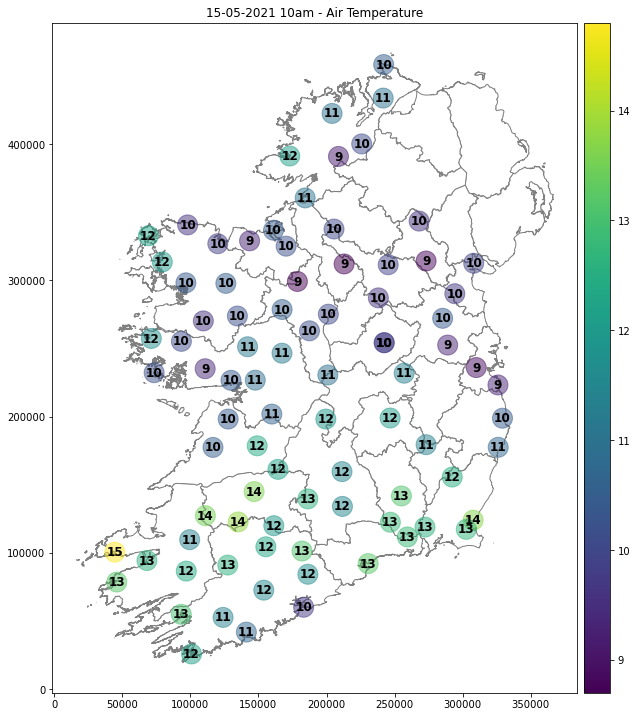

In [9]:
plot_wow_data(gdf_of_interest = gdf_official, type_of_plot = "Air Temperature", 
              buffer_val = 0, flags = None)

In [10]:
gdf_rain_wow, gdf_rain_official, gdf_rain_combined = isolate_data_of_interest(day_of_interest="15", 
                                                                              month_of_interest="05", 
                                                                              year_of_interest="2021", 
                                                                              time_of_interest="10", 
                                                                              type_of_plot="Rainfall Accumulation")

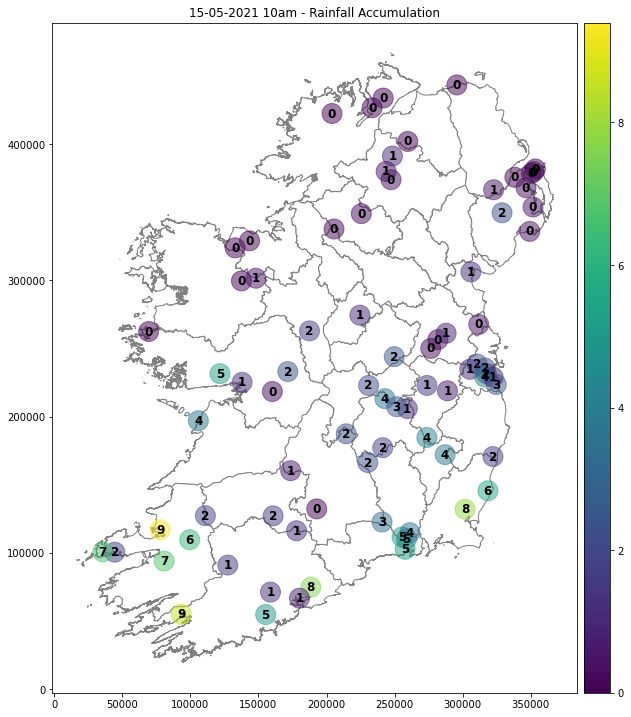

In [11]:
plot_wow_data(gdf_of_interest = gdf_rain_wow, type_of_plot = "Rainfall Accumulation", 
              buffer_val = 0, flags = None)

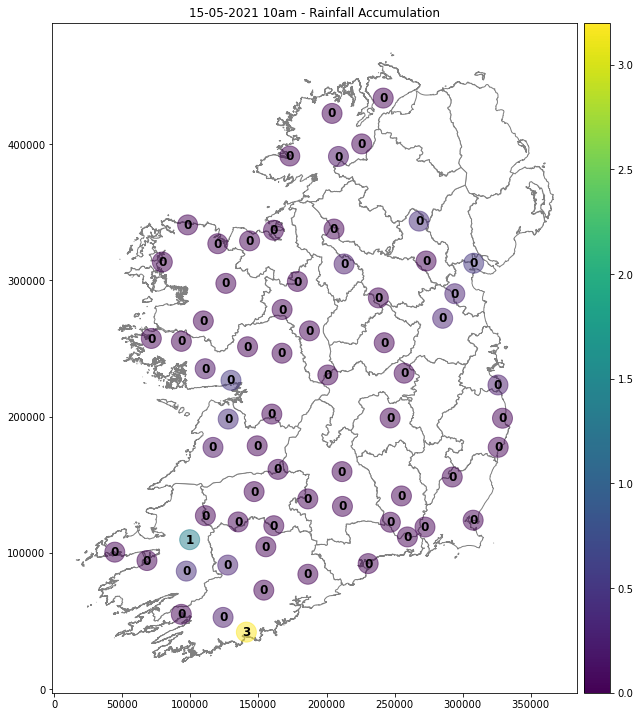

In [12]:
plot_wow_data(gdf_of_interest = gdf_rain_official, type_of_plot = "Rainfall Accumulation", 
              buffer_val = 0, flags = None)

## Isolation Check

In [13]:
long_np = np.array(gdf_combined["Longitude"])
lat_np = np.array(gdf_combined["Latitude"])

points = titanlib.Points(lat_np, long_np)

In [14]:
radius = 15000
num_min = 3

radius2 = 50000
num_min2 = 1

flags = titanlib.isolation_check(points, num_min, radius) # more strict requirements
flags2 = titanlib.isolation_check(points, num_min2, radius2) # very lenient requirements

print(flags)
print("\n")
print(flags2)

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0
 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
custom_points = titanlibcustom.Points(lat_np, long_np)

custom_flags = titanlibcustom.isolation_check(custom_points, num_min, radius)
custom_flags2 = titanlibcustom.isolation_check(custom_points, num_min2, radius2)

print(custom_flags) 
print("\n")
print(custom_flags2) 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


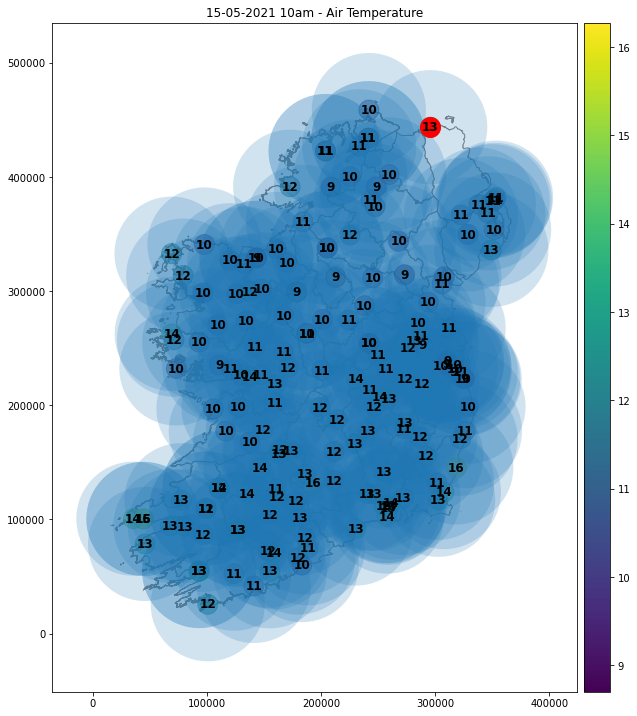

In [16]:
plot_wow_data(gdf_of_interest = gdf_combined, type_of_plot = "Air Temperature", 
              buffer_val = 50000, flags = flags2)